## Structure Learning Notebook

In [1]:
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx
import itertools

from numpy.random import random, choice

### Recovering a tree + Y 

Below we generate a random tree and add the true label RV $Y$, which is connected to everything in the tree. We have $m+1$ nodes, with largest degree $d=m$ (note that we do have side information here, so the largest unknown degree is $d=3$).

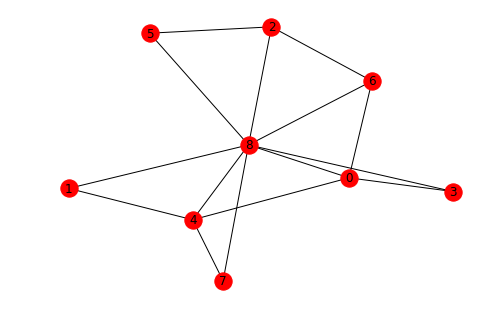

In [2]:
m = 8

# generate a tree
G = nx.random_tree(m)
for i in range(m):
    # Y is connected to everything
    G.add_edge(i,m)
    
# binary Ising model defined over LF nodes, LF edges, Y, and (Y,LF) edges 
t = {}
for node in G.nodes(): t[node] = random() 
for edge in G.edges(): t[edge] = random()

nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

def visualize_matrix(X, fig_size=(10,10)):
    plt.rcParams['figure.figsize'] = fig_size
    plt.imshow(X)
    plt.colorbar()

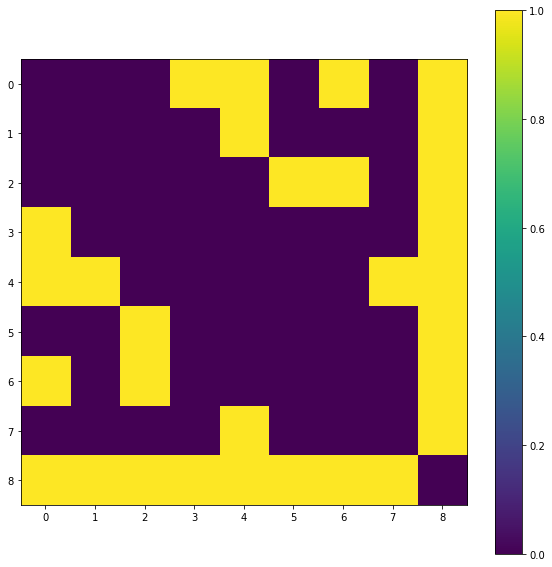

In [3]:
# adjacency matrix visualization:
visualize_matrix(nx.adjacency_matrix(G).todense())

In [4]:
# simple utilities 
def _exp_model(x, t):
    sm = 0
    for node in G.nodes():
        sm += x[node] * t[node]
    for edge in G.edges():
        sm += x[edge[0]] * x[edge[1]] * t[edge]
        
    return np.exp(sm)

# TODO: naive exponential way, replace with junction tree message passing
def _model_sum(x_set, t):
    # x_set contains active variables
    x_un = set.union(*x_set) if x_set else set()
    
    marg_set = set(range(m+1)) - x_un
    marg_set_sz = len(marg_set)
    
    sm = 0
    combs = list(itertools.product([0, 1], repeat=marg_set_sz))
    for l in combs:
        x = np.ones([m+1])
        x[ list(marg_set) ] = l
        sm += _exp_model(x, t)
        
    return sm

# partition function
Z = _model_sum(set(), t)

def prob(x_set, t):
    return _model_sum(x_set, t) / Z

## Structure Check:

Now we can build a covariance matrix---over just nodes, or over nodes+separators. Below we build the full graph with all of the separator sets as a sanity check.

In [5]:
def clique_to_set(cl1):
    xs = set()
    if isinstance(cl1, int): 
        xs.add(cl1)
    else:
        xs = set.union(xs, set(cl1))
    return xs

# builds a covariance matrix for a specified node set (this can contain cliques too, e.g., edges)
def build_matrix(node_set):
    side_cov = len(node_set)
    S = np.zeros([side_cov, side_cov])
    O = np.zeros([side_cov, side_cov])
    mu = np.zeros([side_cov, 1])

    i1 = 0
    i2 = 0
    for clique1 in node_set:
        i2 = 0
        for clique2 in node_set:
            x_set = [clique_to_set(clique1), clique_to_set(clique2)]
            O[i1, i2] = prob(x_set, t)
            i2 += 1
        i1 += 1

    i1 = 0
    for clique1 in node_set:
        x_set = [clique_to_set(clique1)]
        mu[i1] = prob(x_set, t)
        i1 += 1

    S = O - np.outer(mu, mu)
    return S

# Generate the full augmented covariance matrix that contains all separators
S_aug = build_matrix(t.keys())
S_aug_inv = np.linalg.inv(S_aug)
    
# nodes 2 and 3 don't have an edge, check that this is 0
S_aug_inv[2,3]    

-5.104421827089247e-12

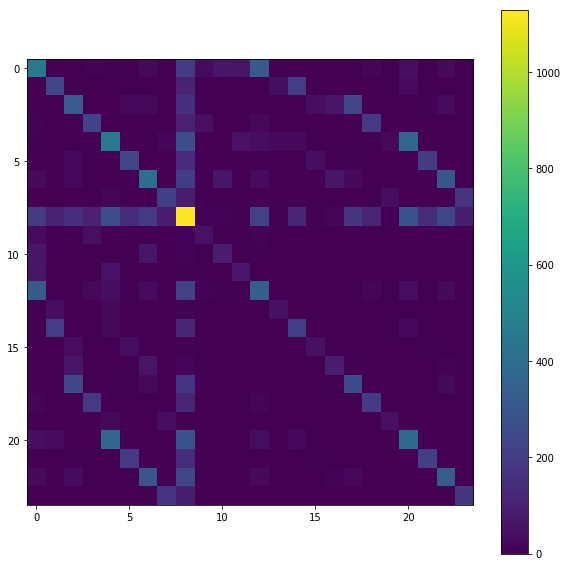

In [6]:
# visualize the 'full' inverse covariance matrix
# note: for structure learning we'd be forming an even bigger graph---we'd have to include every possible edge
visualize_matrix(np.abs(S_aug_inv))

## Supervised Structure Learning

Now we don't know any edges except the $(Y, \lambda_i)$ ones. Instead, we add each separator set to the node set, but sequentally---we never generate the large matrix above. 

We then check the inverse covariance matrix and sequentually build our estimates of the recovered edges.

In [7]:
# non-edges
Omega = []

thr = 10**(-9)

# sequentally add each separator:
# TODO: recursive binary-search style approach to speed this up
for node in G:
    if (node != m):
        nodes = list(G.nodes)
    
        # add the separator (LF_i, Y):
        nodes.append((node, m))

        # build the corresponding matrix:
        S_sep = build_matrix(nodes)
        S_sep_inv = np.linalg.inv(S_sep)
                
        candidates = np.argwhere(np.abs(S_sep_inv) < thr)
        for cand in candidates:
            if cand[0] != cand[1] and cand[0] <= m and cand [1] <= m:
                Omega.append((cand[0], cand[1]))
                
rec_edges = list(set(list(itertools.combinations(range(m+1), r=2))) - set(Omega))

In [8]:
print("recovered edges = ", rec_edges)
print("correct edges = ", G.edges())

sm = 0
for edge in G.edges():
    if edge in rec_edges: sm += 1
print("accuracy: ", sm/len(G.edges()))

#print(Omega)

recovered edges =  [(4, 7), (2, 6), (6, 8), (4, 8), (2, 8), (1, 4), (3, 8), (0, 6), (1, 8), (0, 4), (2, 5), (0, 8), (7, 8), (5, 8), (0, 3)]
correct edges =  [(0, 3), (0, 6), (0, 4), (0, 8), (1, 4), (1, 8), (2, 5), (2, 6), (2, 8), (3, 8), (4, 7), (4, 8), (5, 8), (6, 8), (7, 8)]
accuracy:  1.0


## Unsupervised Structure Learning

Now, we don't even have access to $Y$. We set it up so that we only observe the covariance matrix corresponding to the $\lambda_i$'s.

In [9]:
import cvxpy as cp

# generate the observed S_inv:
obs_nodes = list(G.nodes())
obs_nodes.remove(m)

S_obs = build_matrix(obs_nodes)
S_obs_inv = np.linalg.inv(S_obs)

# max noise. 
delt = 10**(-10)

# prescribed rate lambda
lam = 1/np.sqrt(m)

L = cp.Variable([m, m])
S = cp.Variable([m, m])

objective = cp.Minimize(cp.norm(L, "nuc") + lam * cp.pnorm(S,1))
constraints = [cp.norm(S_obs_inv - L - S, "fro") <= delt]
problm = cp.Problem(objective, constraints)

result = problm.solve()


## Next Steps for Unsupervised

The idea here is that we want to replace the convex solver above (which is agnostic to our approach) with the rank 2 -> rank 1 direct solution. That is, we want a more specific version of RPCA.